# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [1]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("TensorFlow Version {}".format(tf.__version__))

TensorFlow Version 1.3.0


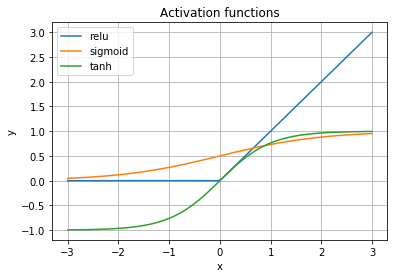

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [4]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training

num_test = 10000

# Load the raw CIFAR-10 data
data_path = "data/cifar-10-batches-py"

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():

    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    all_batches = []
    all_labels = []
    for b in range(1,6):
        f_train_curr = os.path.join(data_path, 'data_batch_%d' % (b, ))
        data, labels = unpickle(f_train_curr)
        batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        labels = np.array(labels)
        all_batches.append(batch)
        all_labels.append(labels)
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    data_val = data_train[mask]
    labels_val = labels_train[mask]
    mask = range(num_training)
    data_train = data_train[mask]
    labels_train = labels_train[mask]
    return data_train, labels_train, data_val, labels_val      
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    f_test = os.path.join(data_path, 'test_batch')
    data, labels = unpickle(f_test)
    data_test = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels_test = np.array(labels)
    mask = range(num_test)
    data_test = data_test[mask]
    labels_test = labels_test[mask]
    return data_test, labels_test
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [5]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def fully_conn(input, kernel_size):
    return tf.layers.dense(input, kernel_size)
    #weights = tf.Variable(tf.truncated_normal([input.get_shape().as_list()[1], kernel_size], mean=0.0, stddev=0.08))
    #bias = tf.Variable(tf.constant(0.05, shape=[kernel_size]))
    #tf.Variable(tf.zeros(kernel_size))
    #fc = tf.matmul(input, weights) + bias
    #return tf.nn.relu(fc)   
    
#def output(input, kernel_size):
    #weights = tf.Variable(tf.truncated_normal([input.get_shape().as_list()[1], kernel_size],mean=0.0,stddev=0.5))
    #bias = tf.Variable(tf.constant(0.05, shape=[kernel_size]))
    #out = tf.add(tf.matmul(input, weights),bias)
    #return out
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional neural network

In [6]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.pool2, [-1, 8 * 8 * 64])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_conn(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_conn(self.relu3, 10)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = None
        self.keep_prob = None
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.train_op = None
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 5e-4
        learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss_op, global_step=global_step)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = None 
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = None  
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_
                }
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            #loss_ = losses[1::100] # sparse the curve a bit
            #plt.plot(loss_, '-o')
            plt.plot(losses, '-o')
            plt.xlabel('Epoch')
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Accuracy')
            plt.plot(accuracies, '-o', label='Training')
            plt.xlabel('Epoch')
            plt.legend(loc='lower right')
            plt.gcf().set_size_inches(15, 12)
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = None
            feed_dict = {
                    self.X: X_,
                    self.Y: Y_
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 22.709, accuracy = 0.094
iteration (50): loss = 1.775, accuracy = 0.352
iteration (100): loss = 1.695, accuracy = 0.406
iteration (150): loss = 1.506, accuracy = 0.375
iteration (200): loss = 1.434, accuracy = 0.500
iteration (250): loss = 1.475, accuracy = 0.469
iteration (300): loss = 1.375, accuracy = 0.508
iteration (350): loss = 1.449, accuracy = 0.492


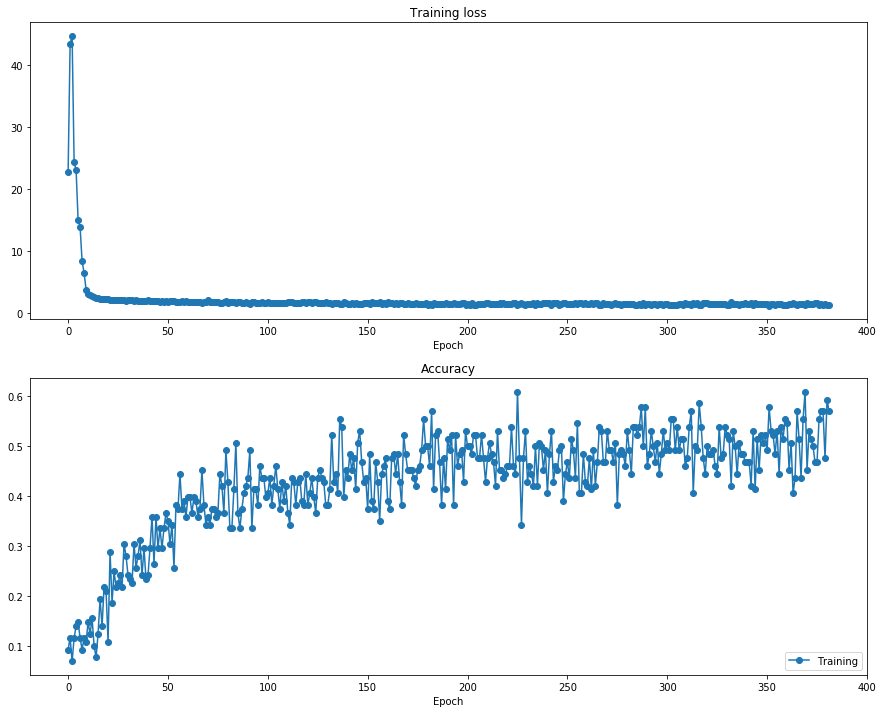

validation for epoch 0
-  epoch 0: validation accuracy = 0.536
train for epoch 1
iteration (400): loss = 1.298, accuracy = 0.562
iteration (450): loss = 1.254, accuracy = 0.586
iteration (500): loss = 1.318, accuracy = 0.531
iteration (550): loss = 1.050, accuracy = 0.633
iteration (600): loss = 1.143, accuracy = 0.617
iteration (650): loss = 1.343, accuracy = 0.508
iteration (700): loss = 1.225, accuracy = 0.602
iteration (750): loss = 1.100, accuracy = 0.617


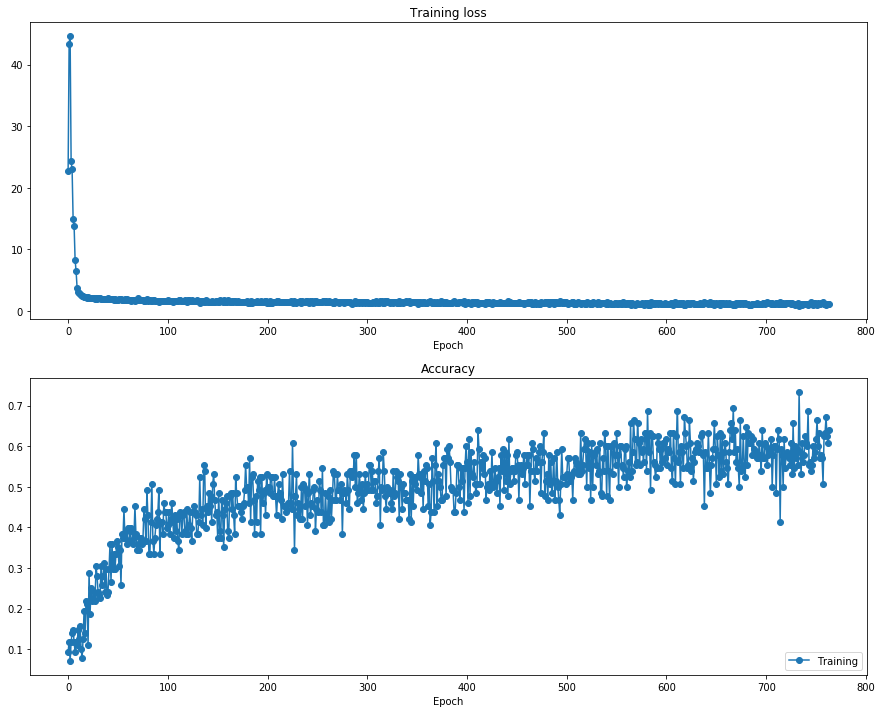

validation for epoch 1
-  epoch 1: validation accuracy = 0.605
train for epoch 2
iteration (800): loss = 0.998, accuracy = 0.625
iteration (850): loss = 1.203, accuracy = 0.602
iteration (900): loss = 0.937, accuracy = 0.664
iteration (950): loss = 0.999, accuracy = 0.641
iteration (1000): loss = 0.899, accuracy = 0.688
iteration (1050): loss = 0.974, accuracy = 0.664
iteration (1100): loss = 0.929, accuracy = 0.648


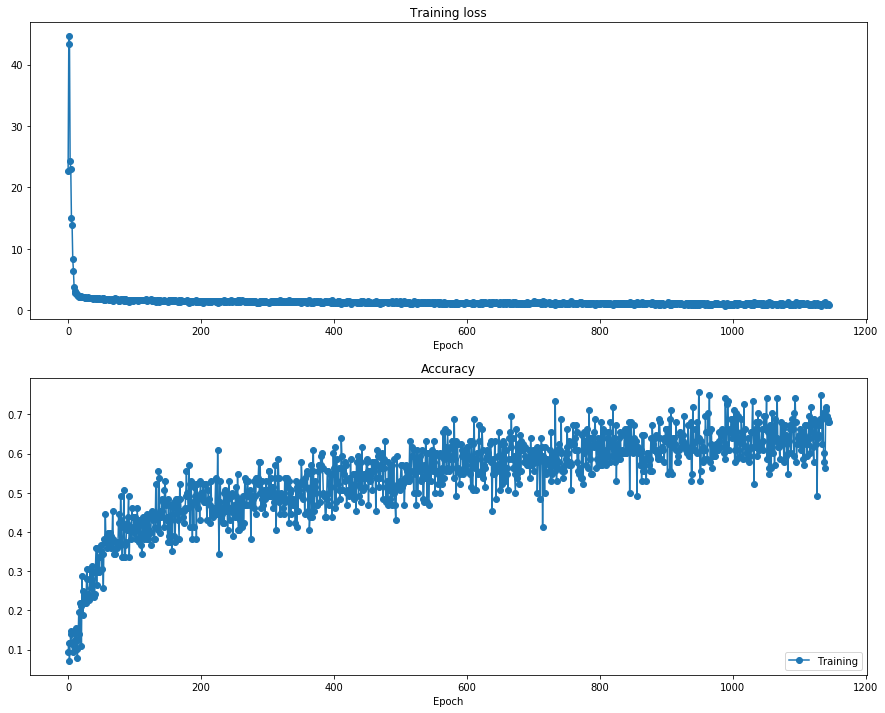

validation for epoch 2
-  epoch 2: validation accuracy = 0.617
train for epoch 3
iteration (1150): loss = 1.101, accuracy = 0.562
iteration (1200): loss = 0.838, accuracy = 0.688
iteration (1250): loss = 0.994, accuracy = 0.633
iteration (1300): loss = 0.971, accuracy = 0.664
iteration (1350): loss = 0.934, accuracy = 0.664
iteration (1400): loss = 0.857, accuracy = 0.742
iteration (1450): loss = 0.881, accuracy = 0.648
iteration (1500): loss = 0.786, accuracy = 0.711


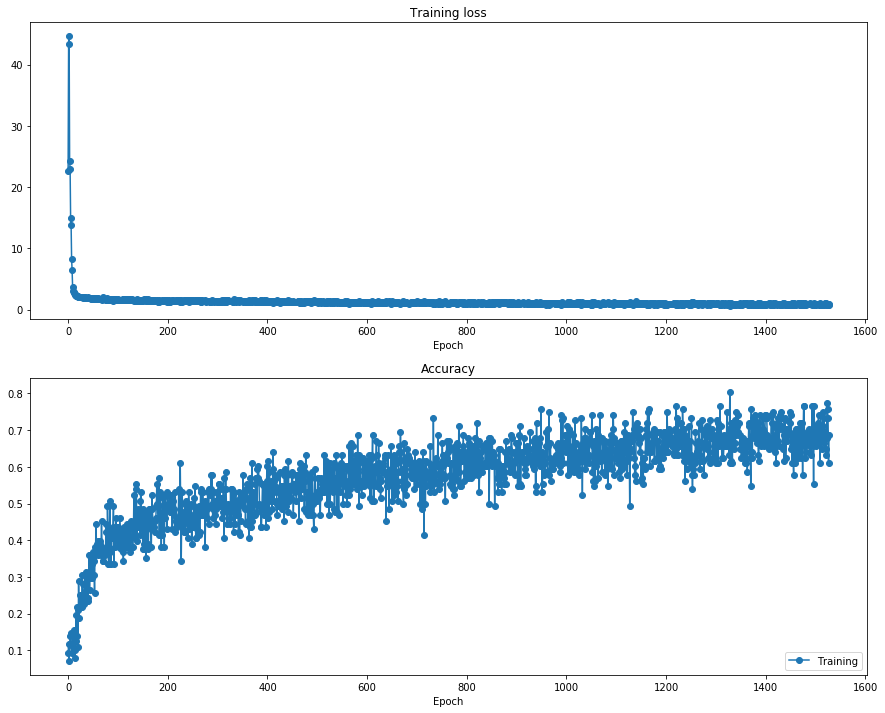

validation for epoch 3
-  epoch 3: validation accuracy = 0.631
train for epoch 4
iteration (1550): loss = 0.764, accuracy = 0.742
iteration (1600): loss = 0.738, accuracy = 0.719
iteration (1650): loss = 1.007, accuracy = 0.664
iteration (1700): loss = 0.818, accuracy = 0.688
iteration (1750): loss = 0.832, accuracy = 0.711
iteration (1800): loss = 0.719, accuracy = 0.727
iteration (1850): loss = 0.733, accuracy = 0.750
iteration (1900): loss = 0.910, accuracy = 0.664


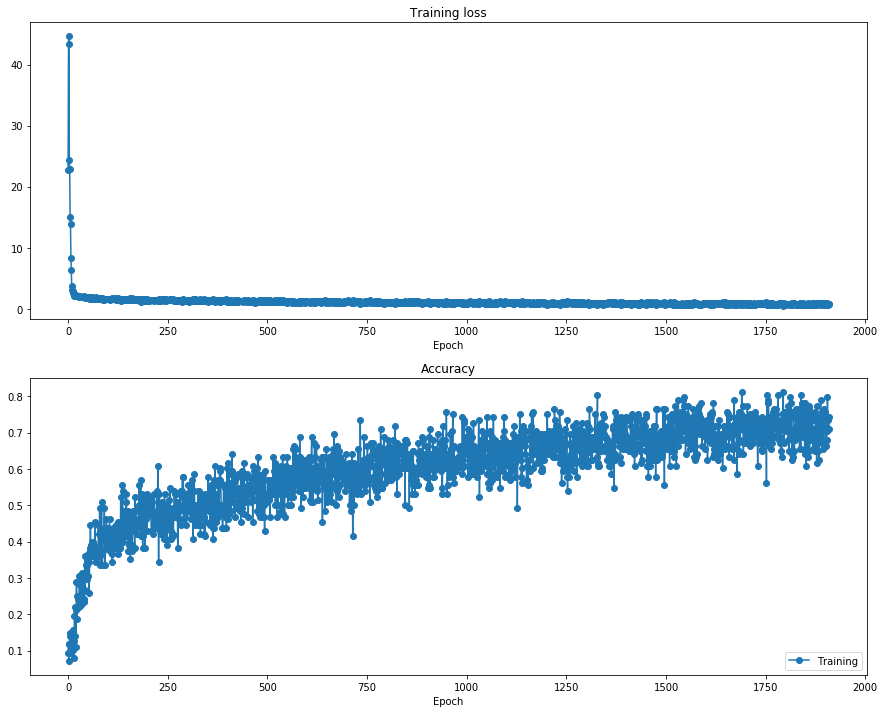

validation for epoch 4
-  epoch 4: validation accuracy = 0.637
***** test accuracy: 0.611
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [7]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [8]:
def normalize(x):
    return x/np.max(x, axis=0)

In [9]:
class YourModel(BaseModel):
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 5
        self.batch_size = 100
        self.log_step = 50

    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = tf.reshape(self.pool2, [-1, 8 * 8 * 64])
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_conn(self.flat, 1024)
            self.relu3 = tf.nn.relu(self.fc3)
            self.full1_drop = tf.nn.dropout(self.relu3, keep_prob=self.keep_prob)

            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.full1_drop.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_conn(self.full1_drop, 10)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    #############################################################################
    # TODO: You can redefine BaseModel's methods                                #
    #############################################################################
    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])  
        self.keep_prob = tf.placeholder(tf.float32) 
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = None       
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.train_op = None
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        #learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           #500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(starter_learning_rate).minimize(self.loss_op, global_step=global_step)
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = None  
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.keep_prob: 0.5
                }
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            # Graph 1. X: epoch, Y: training loss
            plt.subplot(2, 1, 1)
            plt.title('Training loss')
            #loss_ = losses[1::100] # sparse the curve a bit
            #plt.plot(loss_, '-o')
            plt.plot(losses, '-o')
            plt.xlabel('Epoch')
            # Graph 2. X: epoch, Y: training accuracy
            plt.subplot(2, 1, 2)
            plt.title('Accuracy')
            plt.plot(accuracies, '-o', label='Training')
            plt.xlabel('Epoch')
            plt.legend(loc='lower right')
            plt.gcf().set_size_inches(15, 12)
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))
            
    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = None
            feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.keep_prob: 1.0
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 1024)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.322, accuracy = 0.070
iteration (50): loss = 1.848, accuracy = 0.290
iteration (100): loss = 1.714, accuracy = 0.390
iteration (150): loss = 1.774, accuracy = 0.330
iteration (200): loss = 1.631, accuracy = 0.370
iteration (250): loss = 1.437, accuracy = 0.530
iteration (300): loss = 1.464, accuracy = 0.530
iteration (350): loss = 1.279, accuracy = 0.560
iteration (400): loss = 1.214, accuracy = 0.530
iteration (450): loss = 1.109, accuracy = 0.600


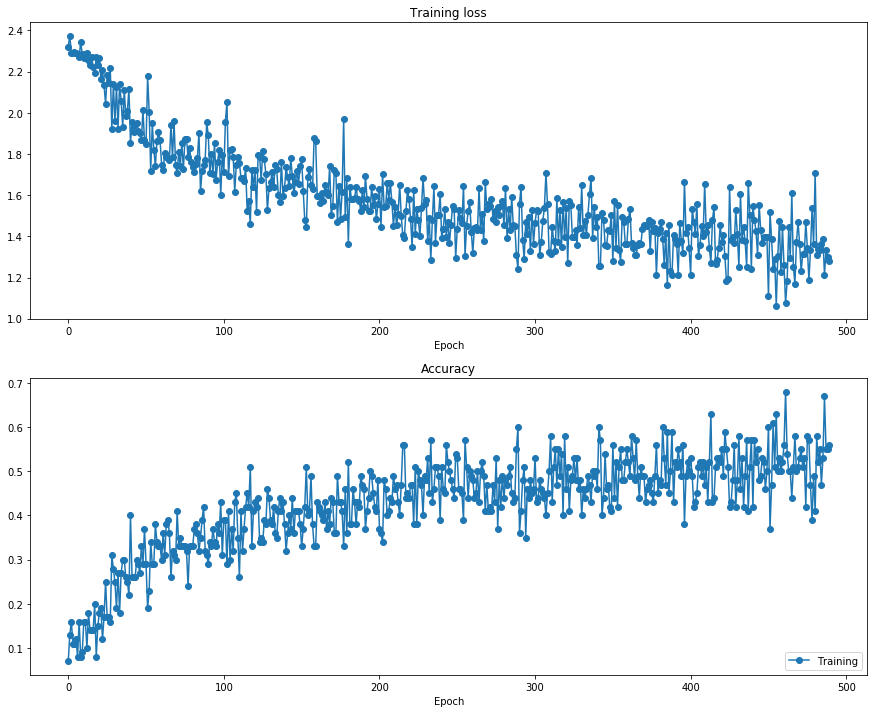

validation for epoch 0
-  epoch 0: validation accuracy = 0.579
train for epoch 1
iteration (500): loss = 1.265, accuracy = 0.510
iteration (550): loss = 1.326, accuracy = 0.530
iteration (600): loss = 1.308, accuracy = 0.520
iteration (650): loss = 1.150, accuracy = 0.560
iteration (700): loss = 1.137, accuracy = 0.580
iteration (750): loss = 1.073, accuracy = 0.610
iteration (800): loss = 1.013, accuracy = 0.660
iteration (850): loss = 1.216, accuracy = 0.580
iteration (900): loss = 1.193, accuracy = 0.610
iteration (950): loss = 1.115, accuracy = 0.580


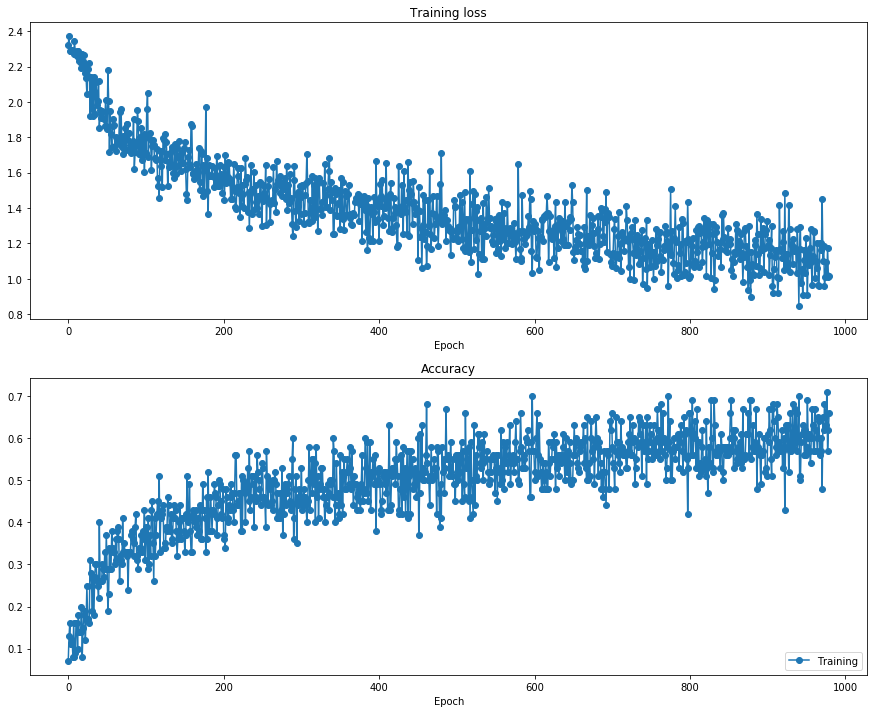

validation for epoch 1
-  epoch 1: validation accuracy = 0.621
train for epoch 2
iteration (1000): loss = 1.145, accuracy = 0.580
iteration (1050): loss = 1.127, accuracy = 0.570
iteration (1100): loss = 1.140, accuracy = 0.590
iteration (1150): loss = 1.049, accuracy = 0.630
iteration (1200): loss = 0.953, accuracy = 0.620
iteration (1250): loss = 1.162, accuracy = 0.550
iteration (1300): loss = 1.122, accuracy = 0.570
iteration (1350): loss = 1.036, accuracy = 0.630
iteration (1400): loss = 1.050, accuracy = 0.670
iteration (1450): loss = 1.096, accuracy = 0.620


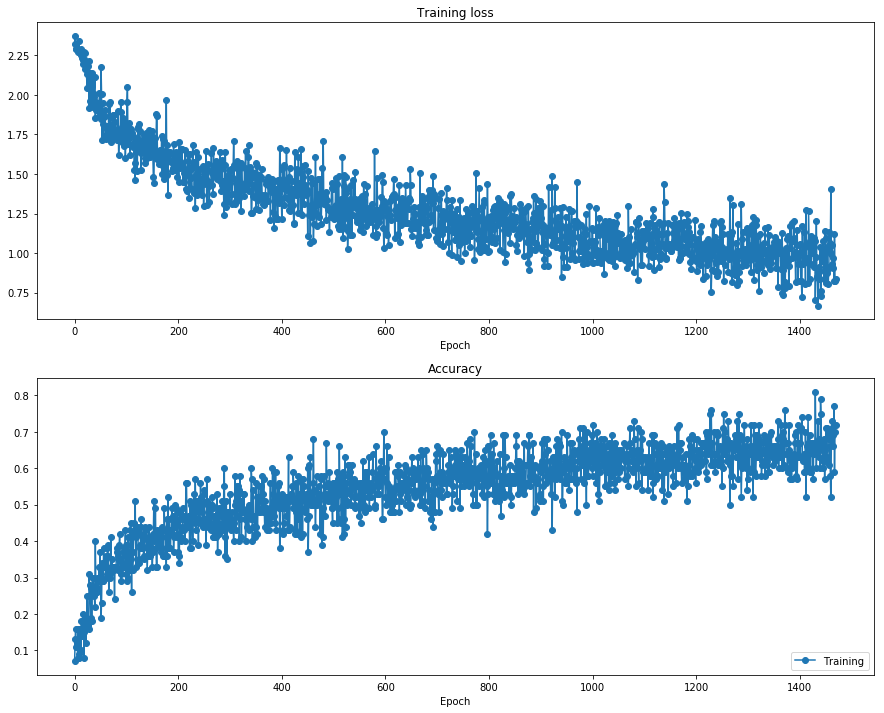

validation for epoch 2
-  epoch 2: validation accuracy = 0.638
train for epoch 3
iteration (1500): loss = 0.966, accuracy = 0.620
iteration (1550): loss = 0.887, accuracy = 0.700
iteration (1600): loss = 1.019, accuracy = 0.700
iteration (1650): loss = 0.809, accuracy = 0.730
iteration (1700): loss = 0.971, accuracy = 0.650
iteration (1750): loss = 0.901, accuracy = 0.670
iteration (1800): loss = 1.175, accuracy = 0.630
iteration (1850): loss = 0.960, accuracy = 0.640
iteration (1900): loss = 0.885, accuracy = 0.660
iteration (1950): loss = 1.197, accuracy = 0.590


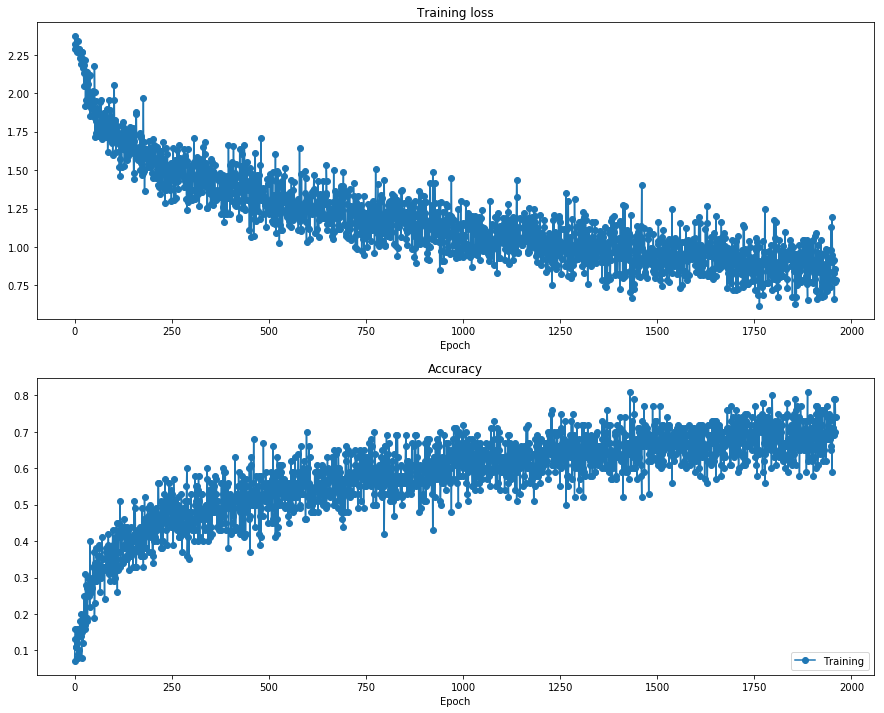

validation for epoch 3
-  epoch 3: validation accuracy = 0.671
train for epoch 4
iteration (2000): loss = 0.723, accuracy = 0.750
iteration (2050): loss = 0.824, accuracy = 0.670
iteration (2100): loss = 0.746, accuracy = 0.750
iteration (2150): loss = 0.842, accuracy = 0.720
iteration (2200): loss = 0.808, accuracy = 0.670
iteration (2250): loss = 0.957, accuracy = 0.660
iteration (2300): loss = 0.845, accuracy = 0.740
iteration (2350): loss = 0.835, accuracy = 0.750
iteration (2400): loss = 0.752, accuracy = 0.750


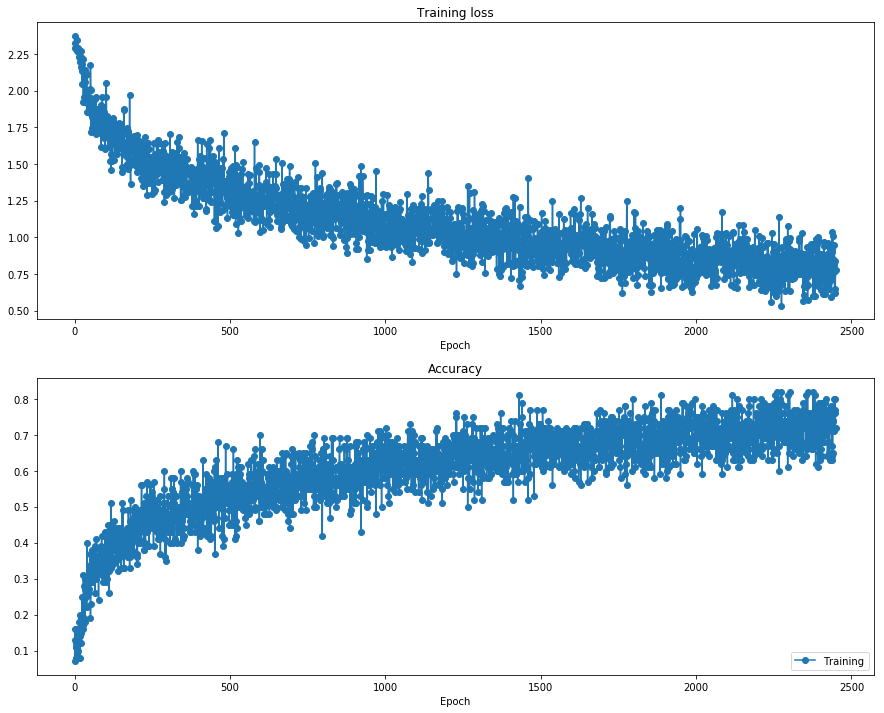

validation for epoch 4
-  epoch 4: validation accuracy = 0.686
***** test accuracy: 0.694
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [10]:
# Clear old computation graphs
tf.reset_default_graph()

sess = tf.Session()

#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = normalize(X_train)
X_val_ = normalize(X_val)
X_test_ = normalize(X_test)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [11]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 1024)
fc4 layer: (?, 10)
INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt


INFO:tensorflow:Restoring parameters from lib/tf_models/problem2/csci-599_mine.ckpt
